In [1]:
# import lettuce and modules
import lettuce as lt
# from lettuce.unit import UnitConversion

from lettuce import (LettuceException, torch_gradient)

# import math, plotting, time etc. basics
import numpy as np
import torch
import time
import datetime
import matplotlib.pyplot as plt

# import specific packages
# from scipy.signal import find_peaks
import os
import psutil
import shutil

# CLASSES & METHODS
def classes and methods for prototyping

In [2]:
class EquilibriumExtrapolationOutlet(lt.AntiBounceBackOutlet):
    """Equilibrium outlet with extrapolated pressure and velocity from inside the domain
    """
    def __init__(self, lattice, direction):
        super(EquilibriumExtrapolationOutlet, self).__init__(lattice, direction)

    def __call__(self, f):
        here = [slice(None)] + self.index
        other = [slice(None)] + self.neighbor
        rho = self.lattice.rho(f)
        u = self.lattice.u(f)
        rho_w = rho[other]
        u_w = u[other]
        f[here] = self.lattice.equilibrium(rho_w[...,None], u_w[...,None])[...,0]
        return f

    def make_no_stream_mask(self, f_shape):
        no_stream_mask = torch.zeros(size=f_shape, dtype=torch.bool, device=self.lattice.device)
        no_stream_mask[[np.setdiff1d(np.arange(self.lattice.Q), self.velocities)] + self.index] = 1
        return no_stream_mask

    def make_no_collision_mask(self, grid_shape):
        no_collision_mask = torch.zeros(size=grid_shape, dtype=torch.bool, device=self.lattice.device)
        no_collision_mask[self.index] = 1
        return no_collision_mask

class ZeroGradientOutlet(object):

    def __init__(self, lattice, direction):
        # assert (isinstance(direction, list) and len(direction) in [1,2,3] and ((np.abs(sum(direction)) == 1) and (np.max(np.abs(direction)) == 1) and (1 in direction) ^ (-1 in direction))), \
        #     LettuceException("Wrong direction. Expected list of length 1, 2 or 3 with all entrys 0 except one 1 or -1, "
        #                         f"but got {type(direction)} of size {len(direction)} and entrys {direction}.")
        self.direction = np.array(direction)
        self.lattice = lattice

        #select velocities to be replaced (the ones pointing against "direction")
        self.velocities = np.concatenate(np.argwhere(np.matmul(self.lattice.stencil.e, self.direction) < -1 + 1e-6), axis=0)  # alles was ENTGEGEN direction zeigt. Also z.B. als Auslass in positive X-Richtung alles, was eine Komponente mit -1 in x-Richtung hat.

        # build indices of u and f that determine the side of the domain
        self.index = []
        self.neighbor = []
        for i in self.direction:
            if i == 0:
                self.index.append(slice(None))
                self.neighbor.append(slice(None))
            if i == 1:
                self.index.append(-1)
                self.neighbor.append(-2)
            if i == -1:
                self.index.append(0)
                self.neighbor.append(1)

    def __call__(self, f):
        f[[self.velocities] + self.index] = f[[self.velocities] + self.neighbor]  # alles, was "aus dem Auslass in Richtung Domäne zeigt" wird vom Nachbar übernommen; Dies kann einen Feedbackloop erzeugen...
        return f

    def make_no_stream_mask(self, f_shape):
        no_stream_mask = torch.zeros(size=f_shape, dtype=torch.bool, device=self.lattice.device)
        no_stream_mask[[self.velocities] + self.index] = 1
        return no_stream_mask

## STAND 29.05.24 läuft die NEX-Boundary MIT no_sreaming (alle pops. besser als > nur velocity_in),OHNE no_collision und OHNE Filter am stabilsten (Re2000 test, s.ohneNote MK Code 13./14./15.5.24)
class NonEquilibriumExtrapolationInletU(object):
    """ Guo's boundary condition
        https://www.researchgate.net/publication/230963379_Non-equilibrium_extrapolation_method_for_velocity_and_boundary_conditions_in_the_lattice_Boltzmann_method
        and LBM book page 189
        """

    def __init__(self, lattice, units, direction, u_w):
        # assert (isinstance(direction, list) and len(direction) in [1,2,3] and ((np.abs(sum(direction)) == 1) and (np.max(np.abs(direction)) == 1) and (1 in direction) ^ (-1 in direction))), \
        #     LettuceException("Wrong direction. Expected list of length 1, 2 or 3 with all entrys 0 except one 1 or -1, "
        #                         f"but got {type(direction)} of size {len(direction)} and entrys {direction}.")
        # print("start nonEQ_init")
        self.direction = np.array(direction)
        self.lattice = lattice
        self.u_w = units.convert_velocity_to_lu(self.lattice.convert_to_tensor(u_w))

        # select velocities to be bounced (the ones pointing in "direction")
        self.velocities_out = np.concatenate(np.argwhere(np.matmul(self.lattice.stencil.e, self.direction) > 1 - 1e-6), axis=0)  # alle, die einen Anteil in direction Richtung haben (nicht nur Betrag)
        # select velocities to be replaced (the ones pointing against "direction")
        self.velocities_in = np.concatenate(np.argwhere(np.matmul(self.lattice.stencil.e, self.direction) < -1 + 1e-6), axis=0)  # alle, die einen Anteil entgegen direction besitzen (nicht nur Betrag)

        # build indices of u and f that determine the side of the domain
        self.index = []
        self.neighbor = []
        for i in self.direction:
            if i == 0:
                self.index.append(slice(None))  # für diese Dimension "alles" ohne
                self.neighbor.append(slice(None))
            if i == 1:
                self.index.append(-1)  # für diese Dimension "letzter"
                self.neighbor.append(-2)  # für diese Dimension "vorletzter"
            if i == -1:
                self.index.append(0)  # für diese Dimension "erster"
                self.neighbor.append(1)  # für diese Dimension "zweiter"
        self.rho_old = 1.0
        if len(self.u_w.shape) > self.lattice.D:
            self.u_w = self.u_w[tuple([slice(None)] + self.index)]
        # print("u_w.shape in init NEQExtrapolInletU:", self.u_w.shape)

    def __call__(self, f):
        Tc = 100
        here = [slice(None)] + self.index  # q Platzhalter und Koordinaten der RB-Knoten
        other = [slice(None)] + self.neighbor  # q Platzhalter und Koordinaten der RB-Nachbarn
        # print("other in NEQEIU.call(): ", other)
        # print("here in NEQEIU.call(): ", here)
        # print("index in NEQEIU.call(): ", self.index)
        # print("f.shape:", f.shape, "f[others].shape:", f[other].shape)

        ## rho = self.lattice.convert_to_tensor(self.lattice.rho(f[other]))
        rho = self.lattice.convert_to_tensor(torch.sum(f[other], dim=0)[None,...])  # berechne für alle Nachbarn die Dichte
        ## u = self.lattice.convert_to_tensor(self.lattice.u(f[other]))  # gibt nur die erste Ebene Knoten aus mit f[other]
        u = self.lattice.convert_to_tensor(torch.einsum("qd,q...->d...", self.lattice.e, f[other]) / rho)  # Geschwindigkeit auf den Nachbarknoten
        
        if self.u_w.shape == u.shape:
            # falls u_w schon die korrekte shape hat, nutze u_w
            u_w = self.u_w
        else:
            list = []
            for _ in u.shape: list += [1]  # pro Dimension in u_w eine 1er Liste anhängen
                # print("len(self.u_w):", len(self.u_w))
            list[0] = len(self.u_w)  # erstes Listen-Objekt wird durch die Dimensionszahl von u_w ersetzt 
                # print("self.u_w.view(list):", self.u_w.view(list))
            u_w = self.u_w.view(list).expand_as(u)
                # print("list:", list)
                # print("u_w.shape:", self.u_w.shape)
                # u_w = self.u_w.view(list)
                # print("u_w.shape:", self.u_w.shape)
                # [3, 80, 60] -> [3, 120, 80, 60]
        
        rho_self = (1 / (1 - u_w[np.argwhere(self.direction != 0).item()] 
                         * self.lattice.e[self.velocities_in[0], np.argwhere(self.direction != 0).item()]) 
                    * (torch.sum(f[[np.setdiff1d(np.arange(self.lattice.Q), [self.velocities_in, self.velocities_out])] 
                                   + self.index] + 2 * f[[self.velocities_out] + self.index], dim=0)))
        
        filter_density = True  # ginge auch über Tc=0 quasi false zu setzen!
        # in Vortests war die Boundary ohne Filter stabiler!
        if filter_density == True:
            # density filtering as proposed by https://www.researchgate.net/publication/257389374_Computational_Gas_Dynamics_with_the_Lattice_Boltzmann_Method_Preconditioning_and_Boundary_Conditions
            rho_w = (rho_self + Tc * self.rho_old) / (1+Tc)
            self.rho_old = rho_w
        else:
            rho_w = rho_self
            self.rho_old = rho_w
        # print("rho_w.shape:", rho_w.shape)
        # print("u_w.shape:", u_w.shape)
        # print("f[other].shape:", f[other].shape)
        # print("rho.shape", rho.shape)
        # print("rho_self.shape:", rho_self.shape)
        # print("u.shape", u.shape)
        
        ## f[here] = self.lattice.equilibrium(rho_w, u_w) + (f[other] - self.lattice.equilibrium(rho, u))  ## EQLM ist anders mit torch.einsum bzw. lattice.einsum definiert... bruh // hier spielt mir die Definition von lettuce.einsum in die Quere, zwischen Martins branch und dem aktuellen Lettuce!
        f[here] = (torch.einsum("q,q...->q...", self.lattice.w, (rho_w * ((2 * torch.tensordot(self.lattice.e, u_w, dims=1) - torch.einsum("d...,d...->...", u_w, u_w)) / (2 * self.lattice.cs ** 2) + 0.5 * (torch.tensordot(self.lattice.e, u_w, dims=1) / (self.lattice.cs ** 2)) ** 2 + 1))) + 
                   (f[other] - torch.einsum("q,q...->q...", self.lattice.w, (rho * ((2 * torch.tensordot(self.lattice.e, u, dims=1) - torch.einsum("d...,d...->...", u, u)) / (2 * self.lattice.cs ** 2) + 0.5 * (torch.tensordot(self.lattice.e, u, dims=1) / (self.lattice.cs ** 2)) ** 2 + 1)))
                    )
                   )
        
        ## >>> VON MIR FALSCH IN AKTUELLES LETTUCE ÜBERSETZT: HIER FEHLTE DAS "_w" AN U UND RHO IM ERSTEN EQUILIBRIUM!
        # f[here] = (torch.einsum("q,q...->q...",self.lattice.w, (rho * ((2 * torch.tensordot(self.lattice.e, u, dims=1) - torch.einsum("d...,d...->...", u, u)) / (2 * self.lattice.cs ** 2) + 0.5 * (torch.tensordot(self.lattice.e, u, dims=1) / (self.lattice.cs ** 2)) ** 2 + 1))) 
        #            + (f[other] - torch.einsum("q,q...->q...", self.lattice.w, (rho * ((2 * torch.tensordot(self.lattice.e, u, dims=1) - torch.einsum("d...,d...->...", u, u)) / (2 * self.lattice.cs ** 2) + 0.5 * (torch.tensordot(self.lattice.e, u, dims=1) / (self.lattice.cs ** 2)) ** 2 + 1)))))
        ## <<<
        return f
    
    nsm_type = 'all'  # 'all', 'q_index', 'None',...
    # Welche relevanten "Arten" Populationen gibt's
    #   - alle, die eine positive x-Komponente haben (velocities_in)  // sollten sowieso überschrieben werden, haben aber im Zweifel für die Berechnung von rho, rho_old, rho_self einen Einfluss?
    #   - alle, die eine negative x-Komponente haben (velocities_out)  // sollten höchstens einen Einfluss auf die Berechnung von rho, rho_old, rho_self haben...
    #   - alle, ohne x-Komponente ("velocities_orthogonal" existiert noch nicht)  // sollten höchstens "Unschärfe" reinbringen...
    #   - alle, die "nur" eine positive oder negative x-Komponente haben ? <- ergibt wenig Sinn
    
    if nsm_type == 'all':  # alle Pops auf der Inlet-Ebene
        # "hardcore" Variante
        # war in Vortests zusammen mit q_index_in die zweitstabilste in Kombination mit q_index_in
        def make_no_stream_mask(self, f_shape):
            no_stream_mask = torch.zeros(size=f_shape, dtype=torch.bool, device=self.lattice.device)
            no_stream_mask[:,0,:,:]=1 # alle Pop auf der ersten Ebene
            return no_stream_mask
    elif nsm_type == 'q_index_in':  # nur velocities_in+index (s.u.) // ZeroGradientOutlet, KineticBoudnaryOutlet, ConvectiveBoundaryOutlet in MK/CD/lettuce Branch (dort ohne "_in")
        # entspricht auch dem auskommentierten im lettuceMPI_new Branch
        ## (!) war in Vortests eine der stabilsten Varianten in Kombination OHNE NCM
        def make_no_stream_mask(self, f_shape):
            no_stream_mask = torch.zeros(size=f_shape, dtype=torch.bool, device=self.lattice.device)
            no_stream_mask[[self.velocities_in] + self.index] = 1
            return no_stream_mask
    # TESTS
    elif nsm_type == 'ABB_outlet_in':
        def make_no_stream_mask(self, f_shape):
            no_stream_mask = torch.zeros(size=f_shape, dtype=torch.bool, device=self.lattice.device)
            no_stream_mask[[np.array(self.lattice.stencil.opposite)[self.velocities_in]] + self.index] = 1
            return no_stream_mask
    elif nsm_type == 'ABB_outlet_out':
        def make_no_stream_mask(self, f_shape):
            no_stream_mask = torch.zeros(size=f_shape, dtype=torch.bool, device=self.lattice.device)
            no_stream_mask[[np.array(self.lattice.stencil.opposite)[self.velocities_out]] + self.index] = 1
            return no_stream_mask
    elif nsm_type == 'EQ_outlet_P_in':
        def make_no_stream_mask(self, f_shape):
            no_stream_mask = torch.zeros(size=f_shape, dtype=torch.bool, device=self.lattice.device)
            no_stream_mask[[np.setdiff1d(np.arange(self.lattice.Q), self.velocities_in)] + self.index] = 1
            return no_stream_mask
    elif nsm_type == 'EQ_outlet_P_out':
        def make_no_stream_mask(self, f_shape):
            no_stream_mask = torch.zeros(size=f_shape, dtype=torch.bool, device=self.lattice.device)
            no_stream_mask[[np.setdiff1d(np.arange(self.lattice.Q), self.velocities_out)] + self.index] = 1 
            return no_stream_mask
    elif nsm_type == 'q_index_out':
        def make_no_stream_mask(self, f_shape):
            no_stream_mask = torch.zeros(size=f_shape, dtype=torch.bool, device=self.lattice.device)
            no_stream_mask[[self.velocities_out] + self.index] = 1
            return no_stream_mask
        
    elif nsm_type == 'SEI':
        def make_no_stream_mask(self, f_shape):
            no_stream_mask = torch.zeros(size=f_shape, dtype=torch.bool, device=self.lattice.device)
            no_stream_mask[[np.concatenate(np.argwhere(np.matmul(self.lattice.stencil.e, [-1, 0, 0]) < -1 + 1e-6), axis=0)] + [0, ...]] = 1  # entspricht bis auf das letzte [0,...] quasi dem, was für die velocities_in für die NEEQInlet rauskommt...
            return no_stream_mask

    ncm_type = False  # 'True', 'False', Collision seams to stabilize the boundary...
    # collision könnte einen abschwächenden Effekt auf die Boundary haben.
    if ncm_type:  # toggle no_collision_mask usage
        def make_no_collision_mask(self, f_shape):
            no_collision_mask = torch.zeros(size=f_shape[1:], dtype=torch.bool, device=self.lattice.device)
            no_collision_mask[self.index] = 1
            return no_collision_mask

class SyntheticEddyInlet(object):
    # according to description in https://doi.org/10.1016/j.jweia.2021.104560 ONLY 3D only in x direction so far

    # NOTES: isotropic fluctuating field is produced on the inlet plane
    # as sum of different made up vorteces

    # fluctuating velocity field that fits prescribed reynolds stree tensor is computed using Cholesky decomposition

    #isotropic gaussian shape function does something?!

    # dann u mit freeflow windspeed addiert

    def __init__(self, lattice, units, grid, L, K, N, R, rho, u_0, velocityProfile, direction=[1, 0, 0]):
        self.lattice = lattice
        self.units = units
        self.grid = grid
        self.rho = rho
        self.L = L
        self.reynolds_stress_tensor = R
        self.u_0 = u_0
        self.K = K
        self.N = N # TODO mal N pro Fläche bei denen und bei mir ausrechnen, ob das passt
        self.direction = direction
        self.velocityProfile = velocityProfile

        # produce N random vorteces 2L downstream from inlet
        self.vorteces = torch.zeros((N, 6), device=self.lattice.device)
        self.vorteces[:, 0] = torch.rand(N, device=self.lattice.device) * -2 * self.L
        for i in range(1, 3):
            self.vorteces[:, i] = torch.rand(N, device=self.lattice.device) * self.units.convert_length_to_pu(torch.tensor(self.grid.shape, device=self.lattice.device))[i]
        self.vorteces[:, 3:6] = torch.rand((N, 3), device=self.lattice.device) - 0.5

        # Cholesky decomposition of prescribed Reynolds stress tensor
        R = self.reynolds_stress_tensor(self.lattice.convert_to_tensor(self.grid()[2][0, :, :]), self.u_0)
        A = torch.zeros_like(R)
        A[..., 0, 0] = torch.sqrt(R[..., 0, 0])
        A[..., 1, 0] = R[..., 1, 0] / A[..., 0, 0]
        A[..., 1, 1] = torch.sqrt(R[..., 1, 1] - A[..., 1, 0] ** 2)
        A[..., 2, 0] = R[..., 2, 0] / A[..., 0, 0]
        A[..., 2, 1] = (R[..., 2, 1] - A[..., 1, 0] * A[..., 2, 0]) / A[..., 1, 1]
        A[..., 2, 2] = torch.sqrt(R[..., 2, 2] - A[..., 2, 0] ** 2 - A[..., 2, 1] ** 2)
        print(f"Redacted Nans: {torch.isnan(A.view(-1)).sum().item()}")
        A = torch.nan_to_num(A, nan=0)
        self.A = A * self.K

        grid = self.lattice.convert_to_tensor(self.grid())
        self.grid_extended = torch.cat((torch.flip(grid[:, 1:4, ...], [1]), grid), dim=1)
        self.grid_extended[0, 0:3, ...] = self.grid_extended[0, 0:3, ...] * -1


    def hasTrueEntrys(self):
        return True

    def __call__(self, f):
        # move vorteces passively at each time step by Uĉ until they pass the inlet... each time a vortex passes the inlet a new one is produced at x - L
        self.vorteces[:, 0] += self.velocityProfile(self.vorteces[:, 2], self.u_0) * self.units.convert_time_to_pu(1) #TODO freeflow windspeed einsetzen (was ist das?)? EXPERIMENTELL: u(z) statt 0.8 * self.u_0
        replace = torch.where((self.vorteces[:, 0] > self.L))[0].tolist()
        if len(replace) > 0:
            self.vorteces[[replace] + [0]] = -self.L
            self.vorteces[[replace], slice(1, 3)] = torch.rand([len(replace), 2], device=self.lattice.device) * self.units.convert_length_to_pu(torch.tensor(self.grid.shape, device=self.lattice.device))[1:3]
            self.vorteces[[replace], slice(3, 6)] = torch.rand([len(replace), 3], device=self.lattice.device) - 0.5

        def shape_fun(x, sigma=0.225):
            return 2 * torch.exp(-1 / (2 * sigma**2) * x**2)

        def calculate_f(u, rho):
            """Initialize the distribution function values. The f^(1) contributions are approximated by finite differences.
            See Krüger et al. (2017).
            """

            grad_u0 = torch_gradient(u[0], dx=1, order=6)[None, ...]

            grad_u1 = torch_gradient(u[1], dx=1, order=6)[None, ...]
            S = torch.cat([grad_u0, grad_u1])

            if self.lattice.D == 3:
                grad_u2 = torch_gradient(u[2], dx=1, order=6)[None, ...]
                S = torch.cat([S, grad_u2])

            Pi_1 = 1.0 * self.units.relaxation_parameter_lu * rho * S / self.lattice.cs ** 2

            Q = (torch.einsum('ia,ib->iab', self.lattice.e, self.lattice.e)
                 - torch.eye(self.lattice.D, device=self.lattice.device,
                             dtype=self.lattice.dtype) * self.lattice.cs ** 2)

            Pi_1_Q = torch.einsum('ab...,iab->i...', Pi_1, Q)
            fneq = torch.einsum('i,i...->i...', self.lattice.w, Pi_1_Q)[:, 3, ...]
            feq = self.lattice.equilibrium(rho[3, ...], u[:, 3, ...])
            return feq - fneq

        u = torch.einsum("xyzN, Nj -> jxyz", (shape_fun((self.grid_extended[0][0:4, :, :, None] - self.vorteces[:, 0]) / self.L) * (shape_fun((self.grid_extended[1][0:4, :, :, None] - self.vorteces[:, 1]) / self.L) + shape_fun((self.grid_extended[1][0:4, :, :, None] - self.vorteces[:, 1] + self.grid_extended[1][4, -1, -1]) / self.L) + shape_fun((self.grid_extended[1][0:4, :, :, None] - self.vorteces[:, 1] - self.grid_extended[1][4, -1, -1]) / self.L)) * shape_fun((self.grid_extended[2][0:4, :, :, None] - self.vorteces[:, 2]) / self.L)), torch.sign(self.vorteces[:, 3:6])) / np.sqrt(self.N)
        u = torch.einsum('...ij, j... -> i...', self.A, u)
        u[0] += self.velocityProfile(self.grid_extended[2][0:4, :, :], self.u_0)
        u = torch.cat((self.units.convert_velocity_to_lu(u), self.lattice.u(f[:, 1:4, ...])), dim=1)
        rho = torch.ones_like(u[0]) * self.rho # TODO ersetzt anderes rho, weil ja p addiert werden sollte und nicht rho?
        #rho = self.units.convert_density_to_pu(self.units.convert_pressure_pu_to_density_lu(0.5 * self.rho * torch.norm(u, dim=0) ** 2))
        # calculate feq and fneq from u and rho
        f[:, 0, :, 1:] = calculate_f(u, self.units.convert_density_to_lu(rho))[..., 1:]
        return f

    def make_no_stream_mask(self, f_shape):
        no_stream_mask = torch.zeros(size=f_shape, dtype=torch.bool, device=self.lattice.device)
        no_stream_mask[[np.concatenate(np.argwhere(np.matmul(self.lattice.stencil.e, [-1, 0, 0]) < -1 + 1e-6), axis=0)] + [0, ...]] = 1
        return no_stream_mask

In [3]:
# houseFlow3D by M.Kliemank, from MA-Thesis-CD-ROM "simulation_code.py"
class HouseFlow3D(object):

    def __init__(self, resolution_x, resolution_y, resolution_z,
                 reynolds_number, mach_number, lattice,
                 char_length_lu, char_length_pu,
                 char_velocity_pu, char_density_pu, 
                 ground_bc='hwbb', house_bc='ibb1',  # 'fwbb', 'hwbb', 'ibb1' 
                 inlet_bc='EQ',  # 'EQ', 'NEX', 'SEI'
                 outlet_bc='EQO',  # 'EQO'
                 heaven_bc='ZGO',  # 'ZGO'
                 K_Factor=10,  # K_factor for SEI boundary inlet
                 L=3,  # L for SEI
                 N=34,  # N number of random voctices for SEI 
                 velocity_profile=0  # velocity profile for SEI boundary
                 ):
        # (K_Factor, L, N, velocity_profile)
        """
            Flow class to simulate the flow around an object (mask) in 3D.
            Parameters:
            resolution_x, resolution_y, resolution_z: domain resolutions, in LU
            lattice: object of the class with the same name from lettuce
            char_length_lu: length of the base of the house, in LU
            char_length_pu: length of the base of the house, in PU
            char_velocity_pu: characteristic velocity (inlet velocity), in PU
            char_density_pu: characteristic density, in PU
        """
        # DOMAIN GRID RESOLUTION AND SHAPE
        self.resolution_x = resolution_x
        self.resolution_y = resolution_y
        self.resolution_z = resolution_z
        self.shape = (self.resolution_x, self.resolution_y, self.resolution_z)
        
        # SEI parameters (see boundary method below)
        self.L=L
        self.N=N
        self.K_Factor=K_Factor
        
        # UNIT CONVERTER AND UNITS
        self.units = lt.UnitConversion(
            lattice,
            reynolds_number=reynolds_number,
            mach_number=mach_number,
            characteristic_length_lu=char_length_lu,
            characteristic_length_pu=char_length_pu,
            characteristic_velocity_pu=char_velocity_pu,
            characteristic_density_pu=char_density_pu,
            characteristic_density_lu=1
        )
        
        # MASKS
        #old:>>
        self._mask = np.zeros(shape=(self.resolution_x, self.resolution_y, self.resolution_z), dtype=bool)
        #<<
        self.solid_mask = np.zeros(shape=self.shape, dtype=bool)  # marks all solid nodes (obstacle, walls, ...)
        if inlet_bc.casefold()=='eq':
            self.in_mask = np.zeros(shape=self.shape, dtype=bool)  # marks all inlet nodes (if EQin is used)
            self.in_mask[0,:,:] = True  # inlet in positive x-direction
        self.ground_mask = np.zeros(shape=self.shape, dtype=bool)  # marks ground on base layer (xy-plane)
        ##self.house_mask = np.zeros(shape=self.shape, dtype=bool)   # marks all nodes inside the house (solid nodes)
        # placeholder for later IBB-implementation
        self.house_mask = self.house([int(self.resolution_x/3),int(self.resolution_y/2),0],eg_x_length=char_length_lu, eg_y_length=char_length_lu, roof_height=char_length_lu*1.25, roof_overhang=0, angle = 45)
        
        self.ground_mask[:,:,0] = True  # mark ground (for standard FWBB/HWBB object-boundary)
        
        self.solid_mask = np.logical_or(self.house_mask, self.ground_mask)  # everything solid for exclusion in initial condition!
        
        # SET boundary-tobbles
        self.ground_bc = ground_bc  # 'fwbb', 'hwbb', 'ibb1' 
        self.house_bc = house_bc    # 'fwbb', 'hwbb', 'ibb1' 
        self.inlet_bc = inlet_bc    # 'EQ', 'NEX', 'SEI'
        # outlet is EquilibriumOutletP
        # heaven is ZeroGradientOutlet
        
        # SET correct z-height for WSP
        x,y,z = self.grid
        self.z_0_PU = 0.5*(z[1,0,0]-z[0,0,0])  # PU_height of z_LU=0.5dx
        

    ### >>> REPLACED BY SEVERAL INDIVIDAL MASKS
    # @property
    # def mask(self):
    #     return self._mask
    # 
    # @mask.setter
    # def mask(self, m):
    #     assert isinstance(m, np.ndarray) and m.shape == self.shape
    #     self._mask = m.astype(bool)
    # <<< 
    # TODO: write masks as properties
    #   - solid_mask should alway be constructed from logical_or(ground,house)
    #   - 
    
    # habe ich (MAX) eingefügt, da wir keine Grid-Klasse haben!)    >>>
    @property
    def grid(self):
        # QUESTION: SHOULD THIS BE ONE- OR ZERO-BASED? Indexing or "node-number"?
        
        ## 0 bis n* l_pu/-_lu in n schritte -> PU-grid-coordinates from LU-Index  
        xyz = tuple(self.units.convert_length_to_pu(np.linspace(0, n, n, endpoint=False)) for n in self.shape)  # tuple of lists of x,y,(z)-values in PU
        return np.meshgrid(*xyz, indexing='ij')  # meshgrid of x-, y- (und z-)values/indices
        
        # OTHER ALTERNATIVES: 
        # >>>
            # PU-grid for link-based boundaries, that place 0 halfway along the link (for example: FWBB, HWBB)
         #   xyz = tuple(self.units.convert_length_to_pu(np.linspace(-0.5, n-0.5, n, endpoint=False)) for n in self.shape)  # tuple of lists of x,y,(z)-values/indices
        
            # PU-grid for link-based boundaries without wallnodes
          #  xyz = tuple(self.units.convert_length_to_pu(np.linspace(0.5, n+0.5, n, endpoint=False)) for n in self.shape) 
        # <<<
    # <<<

    def initial_solution(self, x):
        """Returns the initial macroscopic values (u, rho) at each lattice node
            Initialises speed using the velocity profile function and
            pressure difference from reference pressure as 0

            Inputs:
            x: grid, in LU
        """
        p = np.zeros_like(x[0], dtype=float)[None, ...]
        u = np.zeros((len(x),) + x[0].shape)
        u[0] = self.wind_speed_profile(np.where(self.solid_mask, 0, x[2]),
                                       self.units.characteristic_velocity_pu, 0.25)
        return p, u

    @property
    def boundaries(self):
        """Returns the objects of each boundary class for use by the Simulation class
        """
        x, y, z = self.grid  # meshgrid of PU-coordinates, (0,0,0)PU is on node (0,0,0)LU
        p, u = self.initial_solution(self.grid)  # wind_speed_profile everywhere (in x-direction)
        # print("p.shape, beginning of houes.boudnaries:", p.shape)
        # print("u.shape, beginning of houes.boudnaries:", u.shape)
        # 
        # print("p[0,0, 0, :].shape, beginning of houes.boudnaries:", p[0,0, 0, :].shape)
        # print("u[:,0, 0, :].shape, beginning of houes.boudnaries:", u[:,0, 0, :].shape)
        # in_mask = np.zeros(self.grid[0].shape, dtype=bool)
        # in_mask[0,:]=True
        
        # SEI parameters
        x, y, z = self.grid
        L = self.L
        if self.N == 0:
            N = int(np.ceil((self.units.convert_length_to_pu(self.resolution_y) * self.units.convert_length_to_pu(self.resolution_z)) / (4 * L**2)))
        else:
            N = self.N
        
        #INLET
        if self.inlet_bc.casefold() == 'eq':
            inlet_boundary_condition = lt.EquilibriumBoundaryPU(np.abs(x) < 1e-6, self.units.lattice, self.units, u[:,0, np.newaxis, ...], p[0,0, :, :])
            # inlet_boundary_condition = lt.EquilibriumBoundaryPU(np.abs(x) < 1e-6, self.units.lattice, self.units, u[:, 0, ...], p[0, 0, ...])
        elif self.inlet_bc.casefold() == 'nex':
            inlet_boundary_condition = NonEquilibriumExtrapolationInletU(self.units.lattice, self.units, [-1, 0, 0], np.array(u))  # original aus der Arbeit
        elif self.inlet_bc.casefold() == 'sei':
            inlet_boundary_condition = SyntheticEddyInlet(self.units.lattice, 
                                                             self.units, 
                                                             self.grid, # previously "self.rgrid"
                                                             rho=self.units.convert_density_to_pu(self.units.convert_pressure_pu_to_density_lu(0)), 
                                                             u_0=self.units.characteristic_velocity_pu, 
                                                             K=self.K_Factor*10, 
                                                             L=L, N=N, R=self.reyolds_stress_tensor, 
                                                             velocityProfile=self.wind_speed_profile)
        else:
            print("(!) flow-class encountered illegal inlet_bc-parameter! Using EquilibriumBoundaryPU")
            inlet_boundary_condition = lt.EquilibriumBoundaryPU(np.abs(x) < 1e-6, self.units.lattice, self.units, u[:,0, np.newaxis, ...], p[0,0, :, :])
        
        #OUTLET BACK
        #outlet_boundary_condition = lt.EquilibriumOutletP(self.units.lattice, [1, 0, 0], rho0=self.units.convert_pressure_pu_to_density_lu(0))
        out_mask = np.zeros_like(self.solid_mask)
        out_mask[-1,:,:] = True
        outlet_boundary_condition = lt.EquilibriumBoundaryPU(out_mask, self.units.lattice, self.units, u[:,-1, np.newaxis, ...], p[0,-1, :, :])
        
        #OUTLET TOP ("heaven")
        #heaven_boundary_condition = ZeroGradientOutlet(self.units.lattice, [0, 0, 1])
        heaven_mask = np.zeros_like(self.solid_mask)
        heaven_mask[:,:,-1] = True
        heaven_boundary_condition = lt.EquilibriumBoundaryPU(heaven_mask, self.units.lattice, self.units, u)
        #TODO: make ground and house BB choosable -> fwb, hwbb, ibb1 / compact?
        
        #GROUND
        ground_boundary_condition = lt.BounceBackBoundary(self.ground_mask, self.units.lattice)
        
        #HOUSE
        house_boundary_condition = lt.BounceBackBoundary(self.house_mask, self.units.lattice)
        
        return [
            inlet_boundary_condition,
            outlet_boundary_condition,
            heaven_boundary_condition,
            ground_boundary_condition,
            house_boundary_condition
        ]
    
        # test with house and ground being combined into one boundary
        # return [
        #     inlet_boundary_condition,
        #     outlet_boundary_condition,
        #     heaven_boundary_condition,
        #     lt.FullwayBounceBackBoundary(self.solid_mask,self.units.lattice)
        # ]
        
#         return [
#             lt.BounceBackBoundary(self.mask | (z < 1e-6), self.units.lattice), # quasi gleich
#             ZeroGradientOutlet(self.units.lattice, [0, 0, 1]),
#             lt.EquilibriumOutletP(self.units.lattice, [1, 0, 0]),
#             NonEquilibriumExtrapolationInletU(self.units.lattice, self.units, [-1, 0, 0], np.array(u))  # original aus der Arbeit
#             # lt.EquilibriumBoundaryPU(np.abs(x) < 1e-6, self.units.lattice, self.units, u[:, 0, ...], p[0, 0, ...])  # EQ aus house3D_final_new2_noverhang.py
# #            lt.EquilibriumBoundaryPU(np.abs(x) < 1e-6, self.units.lattice, self.units, u[:,0, np.newaxis, ...], p[0,0, :, :])  # so funktioniert EQ aus house3D_final_new2_noverhang.py
#         ]

    def house(self, o, eg_x_length, eg_y_length,
              roof_height, roof_overhang=0, angle=35):
        """Outputs mask for flow: house with square base
            and gable-roof parallel to y direction and overhang

            Inputs:
            eg_x_length: length of the house base in x-direction, in LU
            eg_y_length: length of the house base in y-direction, in LU
            roof_height: height of the top of the roof, in LU

        """
        angle = angle * np.pi / 180
        eg_height = int(round(roof_height - (eg_x_length / 2 + roof_overhang)
                              * np.tan(angle)))
        self.roof_height = roof_height
        inside_mask = np.zeros_like(self.grid[0], dtype=bool)
        inside_mask[int(o[0] - eg_x_length / 2):int(o[0] + eg_x_length / 2),
                    int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2),
                    :eg_height] = True
        inside_mask[int(o[0] - eg_x_length / 2 - roof_overhang):
                    int(o[0] + eg_x_length / 2 + roof_overhang),
                    int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2), 
                    eg_height] = True
        inside_mask[int(o[0] - eg_x_length / 2 - roof_overhang):
                    int(o[0] + eg_x_length / 2 + roof_overhang),
                    int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2), 
                    eg_height + 1:] = \
            np.where(self.units.convert_length_to_lu(self.grid[2][int(o[0] - eg_x_length / 2 - roof_overhang):int(o[0] + eg_x_length / 2 + roof_overhang),
                                                                  int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2), eg_height + 1:]
                                                     ) 
                     < o[2] + roof_height + 0.5 - np.tan(angle) * np.abs(self.units.convert_length_to_lu(
                                 self.grid[0][int(o[0] - eg_x_length / 2 - roof_overhang):int(o[0] + eg_x_length / 2 + roof_overhang),
                                              int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2),
                                              eg_height + 1:]
                                                                                                         ) - o[0]),
                     True,
                     inside_mask[int(o[0] - eg_x_length / 2 - roof_overhang):int(o[0] + eg_x_length / 2 + roof_overhang),
                                 int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2), 
                                 eg_height + 1:])
        return inside_mask
    
    # TEST METHODS
    def house1(self, o, eg_length, eg_width, eg_height, roof_length, roof_width, angle):
        o[2] = 0  # verschiebe Ursprungs z-Koordinate auf 0
        angle = angle * np.pi / 180  #rechne Winkel in Bogenmaß um 
        
        # Solid-Mask des Hauses
        inside_mask = np.zeros_like(self.grid[0], dtype=bool)
        inside_mask = np.where(np.logical_and(
                                np.logical_and(np.logical_and(o[0] - eg_length / 2 < self.grid[0], self.grid[0] < o[0] + eg_length / 2),
                                               np.logical_and(o[1] - eg_width / 2 < self.grid[1], self.grid[1] < o[1] + eg_width / 2)
                                               ), 
                                np.logical_and(o[2] - eg_height <= self.grid[2], self.grid[2] <= o[2] + eg_height)
                                              ), 
                               True, inside_mask)
        # wo o_x-eg_length/2 < grid_x < o_x+eg_length/2
        #   UND: o_y-eg_width/2 < grid_y < o_y+eg_width/2
        #   UND: o_z-eg_height <= grid_z <= o_z+eg_height  <- das hier ist wierd, weils bis in den Boden geht^^
        # => das resultiert in einem symmetrischen Quader um den Urpsprung o, d.h. aber auch, dass das ganze  wenn o[2]=0 ist, im Boden liegt? -> oder ist das in PU?
        inside_mask = np.where(np.logical_and(
                                  np.logical_and(
                                     np.logical_and(
                                          np.logical_and(o[0] - roof_length / 2 < self.grid[0], self.grid[0] < o[0] + roof_length / 2),
                                          np.logical_and(o[1] - roof_width / 2 < self.grid[1], self.grid[1] < o[1] + roof_width / 2)
                                                    ),
                                     np.logical_and(o[2] + eg_height < self.grid[2], self.grid[2] < o[2] + eg_height + 0.001 + np.tan(angle) * (self.grid[0] - o[0] + roof_width / 2))
                                                 ),
                                  self.grid[2] < o[2] + eg_height + 0.001 - np.tan(angle) * (self.grid[0] - o[0] - roof_width / 2)
                                               ), 
                                True, inside_mask)
        # wo: o_x-roof_length/2 < grid_x < o_x + roof_length/2
        #   UND: o_y-roof_width/2 < grid_y < o_y + roof_width/2
        #   UND: o_z + eg_heigth < grid_z < o_z + eg_heigth + 0.001 + tan(angle)*(grid_x-o_x+roof_width/2)
        #   UND: grid_z < o_z + eg_height + 0.001 - tan(angle)*(grid_x+o_x-roof_width/2)
        # => das resultiert im Dachgiebel. Dachrechteck-Aufsicht in x und y und dann Höhe dieser Punkte abh. von ihrer x-Koordinate
    
        """make masks for fs to be bounced / not streamed by going over all obstacle points and
        following all e_i's to find neighboring points and which of their fs point towards the obstacle
        (fs pointing to obstacle are added to no_stream_mask, fs pointing away are added to bouncedFs)"""
    
        # ERSTELLE MASKE ALLER Pops, die aus dem Haus raus strömen
        x, y, z = inside_mask.shape
        outgoing_mask = np.zeros((self.units.lattice.Q, x, y, z), dtype=bool)
        a, b, c = np.where(inside_mask)
        for p in range(0, len(a)):
            for i in range(0, self.units.lattice.Q):
                try:  # try in case the neighboring cell does not exist (an f pointing out of simulation domain)
                    if not inside_mask[a[p] + self.units.lattice.stencil.e[i, 0], b[p] + self.units.lattice.stencil.e[i, 1], c[p] + self.units.lattice.stencil.e[i, 2]]:
                        outgoing_mask[i, a[p] + self.units.lattice.stencil.e[i, 0], b[p] + self.units.lattice.stencil.e[i, 1], c[p] + self.units.lattice.stencil.e[i, 2]] = 1
                except IndexError:
                    pass  # just ignore this iteration since there is no neighbor there
    
        # ERSTELLE Messpunkte als x,y,z Tupel
        # erstelle Punkte in der x,y Ebene
        measurement_points = []
        measurement_points.append(o + np.asarray([roof_length * 0.25, -roof_width * 0.25, 0]))
        measurement_points.append(o + np.asarray([roof_length * 0.75, -roof_width * 0.25, 0]))
        measurement_points.append(o + np.asarray([roof_length * 0.25, roof_width * 0.25, 0]))
        measurement_points.append(o + np.asarray([roof_length * 0.75, roof_width * 0.25, 0]))
        measurement_points.append(o + np.asarray([roof_length * 0.5, 0, 0]))
    
        # weise Punkten korrekte z-Höhe zu
        for point in measurement_points:
            point[2] = eg_height + 0.001 - np.tan(angle) * (point[0] - o[0] - roof_width / 2)
            for i in range(0, 3):
                point[i] = int(self.units.convert_length_to_lu(point[i]))
            point[2] += 2
    
        return inside_mask #, measurement_points
    
    def house2(self, o, eg_x_length, eg_y_length, roof_height, roof_overhang, roof_width=0, angle=45):
        if roof_width == 0:  # OPTION FÜR seitlichen Überhang
            roof_width=eg_y_length
        o[2] = 0
        angle = angle * np.pi / 180
        
        #EG_HEIGHT (abh. von roof_height)
        eg_height = roof_height - (eg_x_length / 2 + roof_overhang) * np.tan(angle)  # ERRECHNE eg_height
        self.eg_height = eg_height
        
        
        # SOLID MASK
        inside_mask = np.zeros_like(self.grid[0], dtype=bool)
        
        # EG-Würfel
        inside_mask = np.where(np.logical_and(
            np.logical_and(np.logical_and(o[0] - eg_x_length / 2 < self.grid[0], self.grid[0] < o[0] + eg_x_length / 2),
                           np.logical_and(o[1] - eg_y_length / 2 < self.grid[1], self.grid[1] < o[1] + eg_y_length / 2)),
                            np.logical_and(o[2] - eg_height <= self.grid[2], self.grid[2] <= o[2] + eg_height)), True, inside_mask)
        # DACH Prisma mit overhang
        inside_mask = np.where(np.logical_and(
                        np.logical_and(np.logical_and(o[0] - eg_x_length / 2 - roof_overhang < self.grid[0], self.grid[0] < o[0] + eg_x_length / 2 + roof_overhang),
                        np.logical_and(o[1] - roof_width / 2 < self.grid[1], self.grid[1] < o[1] + roof_width / 2)),
                        np.logical_and(o[2] + eg_height < self.grid[2],
                        self.grid[2] < o[2] + roof_height + 0.001 - np.tan(angle) * np.abs(self.grid[0] - o[0]))), True, inside_mask)
        #inside_mask = np.where(np.logical_and(
        #                np.logical_and(np.logical_and(o[0] - eg_x_length / 2 - roof_overhang < self.grid[0],self.grid[0] < o[0] + eg_x_length / 2 + roof_overhang),
        #                np.logical_and(o[1] - roof_width / 2 < self.grid[1],self.grid[1] < o[1] + roof_width / 2)),
        #                np.logical_and(o[2] + eg_height < self.grid[2],
        #                self.grid[2] < o[2] + eg_height + self.units.convert_length_to_pu(1.5))), True, inside_mask)
    
        """make masks for fs to be bounced / not streamed by going over all obstacle points and
        following all e_i's to find neighboring points and which of their fs point towards the obstacle
        (fs pointing to obstacle are added to no_stream_mask, fs pointing away are added to bouncedFs)"""
    
        # x, y, z = inside_mask.shape
        # outgoing_mask = np.zeros((self.units.lattice.Q, x, y, z), dtype=bool)
        # a, b, c = np.where(inside_mask)
        # for p in range(0, len(a)):
        #     for i in range(0, self.units.lattice.Q):
        #         try:  # try in case the neighboring cell does not exist (an f pointing out of simulation domain)
        #             if not inside_mask[a[p] + self.units.lattice.stencil.e[i, 0], b[p] + self.units.lattice.stencil.e[i, 1], c[p] + self.units.lattice.stencil.e[i, 2]]:
        #                 outgoing_mask[i, a[p] + self.units.lattice.stencil.e[i, 0], b[p] + self.units.lattice.stencil.e[i, 1], c[p] + self.units.lattice.stencil.e[i, 2]] = 1
        #         except IndexError:
        #             pass  # just ignore this iteration since there is no neighbor there
        # 
        # #auf dem Dach:
        # measurement_points = []
        # measurement_points.append(o + np.asarray([(eg_y_length / 2 + roof_overhang) * 0.25, -roof_width * 0.25, 0]))
        # measurement_points.append(o + np.asarray([(eg_y_length / 2 + roof_overhang) * 0.75, -roof_width * 0.25, 0]))
        # measurement_points.append(o + np.asarray([(eg_y_length / 2 + roof_overhang) * 0.25, roof_width * 0.25, 0]))
        # measurement_points.append(o + np.asarray([(eg_y_length / 2 + roof_overhang) * 0.75, roof_width * 0.25, 0]))
        # measurement_points.append(o + np.asarray([(eg_y_length / 2 + roof_overhang) * 0.5, 0, 0]))
        # 
        # #auf der Vorderseite vom Dach?
        # 
        # measurement_points.append(o - np.asarray([(eg_y_length / 2 + roof_overhang) * 0.25, -roof_width * 0.25, 0]))
        # measurement_points.append(o - np.asarray([(eg_y_length / 2 + roof_overhang) * 0.75, -roof_width * 0.25, 0]))
        # measurement_points.append(o - np.asarray([(eg_y_length / 2 + roof_overhang) * 0.25, roof_width * 0.25, 0]))
        # measurement_points.append(o - np.asarray([(eg_y_length / 2 + roof_overhang) * 0.75, roof_width * 0.25, 0]))
        # measurement_points.append(o - np.asarray([(eg_y_length / 2 + roof_overhang) * 0.5, 0, 0]))
        # 
        # for point in measurement_points:
        #     point[2] = o[2] + roof_height + 0.001 - np.tan(angle) * np.abs(point[0] - o[0])
        #     for i in range(0, 3):
        #         point[i] = int(self.units.convert_length_to_lu(point[i]))
        #     point[2] += 2
        # 
        # measurement_points += [point + np.array([0, 0, 8]) for point in measurement_points[0:10]]
        # measurement_points += [point + np.array([0, 0, 18]) for point in measurement_points[0:10]]
        # 
        #     # im freien Raum vor dem Haus
        # 
        # measurement_points.append(np.asarray([int(self.units.convert_length_to_lu(x)) for x in [self.grid.shape[0] * 0.05, self.grid.shape[1] / 2, self.grid.shape[2] / 2]]))
    
        return inside_mask #, measurement_points
    
    def house3a(self, o, eg_x_length, eg_y_length, eg_height, roof_overhang, roof_width=0, angle=45):
        # In LU, weil da sonst immer alles nicht stimmt^^ alles außer Winkel ist jetzt in LU roof_width gibts nich
        angle = angle * np.pi / 180
        self.eg_height = eg_height  # EG_Height unabhängig
        roof_width = eg_y_length
        
        # SOLID MASK
        inside_mask = np.zeros_like(self.grid[0], dtype=bool)
        
        # EG-Würfel
        inside_mask[int(o[0] - eg_x_length / 2):int(o[0] + eg_x_length / 2),
                    int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2), 
                    :eg_height] = True
        # erste Dach-Schicht mit Überhang in x-Richtung
        inside_mask[int(o[0] - eg_x_length / 2 - roof_overhang):int(o[0] + eg_x_length / 2 + roof_overhang),
                    int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2), 
                    eg_height] = True
        
        # DACH Prisma ab eg_height+1 aufwärts (inkl. Overhang)
        #   z-height kleiner als "Dachoberfläche", x um (o_x+eg_x_length/2) reduziert für den tangens und erhöht für tangens (sollte vorder und Rückseite sein?)
        #   t-Höhe wird um 0.001 toleranz verglichen für Rechenfehler (wird ja in LU verglichen)
        inside_mask[int(o[0] - eg_x_length / 2 - roof_overhang):int(o[0] + eg_x_length / 2 + roof_overhang),
                    int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2), eg_height + 1:] = \
            np.where(np.logical_and(self.units.convert_length_to_lu(
                self.grid[2][int(o[0] - eg_x_length / 2 - roof_overhang):int(o[0] + eg_x_length / 2 + roof_overhang),int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2), eg_height + 1:]  # z height
                                                                    ) < o[2] + eg_height + 0.001 - np.tan(angle) * (self.units.convert_length_to_lu(
                    self.grid[0][int(o[0] - eg_x_length / 2 - roof_overhang):int(o[0] + eg_x_length / 2 + roof_overhang),int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2), eg_height + 1:]  # x for tangens
                                                                        ) - o[0] - eg_x_length/2),  # PLUS
                                    self.units.convert_length_to_lu(
                self.grid[2][int(o[0] - eg_x_length / 2 - roof_overhang):int(o[0] + eg_x_length / 2 + roof_overhang),int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2), eg_height + 1:]  # z height
                                                                    ) < o[2] + eg_height + 0.001 + np.tan(angle) * (self.units.convert_length_to_lu(
                    self.grid[0][int(o[0] - eg_x_length / 2 - roof_overhang):int(o[0] + eg_x_length / 2 + roof_overhang),int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2), eg_height + 1:]  # x for tangens
                                                                        ) - o[0] + eg_x_length/2)), # MINUS
                     True, 
                     inside_mask[int(o[0] - eg_x_length / 2 - roof_overhang):int(o[0] + eg_x_length / 2 + roof_overhang), int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2), eg_height + 1:])
        
        # CREATE MESHGRID for measurement_points
        x = np.linspace(-0.1, 0.5, 7, endpoint=True)
        y = np.linspace(-0.5, 0.5, 11, endpoint=True)
        xy = np.meshgrid(y, x)
        # xy[x/y, x, y]
        measurement_points = np.asarray([(eg_x_length / 2 + roof_overhang) * xy[1], eg_y_length * xy[0], np.zeros_like(xy[0])])
    
        meas_points = []
        meas_points2 = []
        meas_points3 = []
        meas_points4 = []
    
        if 0:
            for y in range(0, 10):
                for x in range(0, 6):
                    measurement_points[:, x, y] = measurement_points[:, x, y] + o
                    measurement_points[2, x, y] = roof_height + 0.001 - np.tan(angle) * np.abs(measurement_points[0, x, y] - o[0])
                    measurement_points[:, x, y] = measurement_points[:, x, y].astype(np.int32)
                    meas_points.append(measurement_points[:, x, y].astype(np.int32))
                    meas_points2.append(measurement_points[:, x, y] + np.asarray([0, 0, 1]))
                    meas_points3.append(measurement_points[:, x, y] + np.asarray([0, 0, 2]))
                    meas_points4.append(measurement_points[:, x, y] + np.asarray([0, 0, 3]))
    
            measurement_points = meas_points + meas_points2 + meas_points3  + meas_points4
    
            middle_front = np.asarray([(eg_x_length / 2 + roof_overhang) * -0.25, 0, roof_height + 0.001 - np.tan(angle) * np.abs((eg_x_length / 2 + roof_overhang) * -0.25)]) + np.asarray(o)
            for i in range(0, 3):
                measurement_points.append(middle_front.astype(np.int32) + np.asarray([0, 0, i]))
            # Hinter dem Einlass
            measurement_points.append(np.asarray([int(self.units.convert_length_to_lu(x)) for x in
                                                  [self.grid.shape[0] * 0.05, self.grid.shape[1] / 2,
                                                   self.grid.shape[2] / 2]]))
        measurement_points=[]
        return inside_mask #, measurement_points
    
    def house3a_newMPI(self, o, eg_x_length, eg_y_length, roof_height, roof_overhang, roof_width=0, angle=45):
        #In LU, weil da sonst immer alles nicht stimmt^^ alles außer Winkel ist jetzt in LU roof_width gibts nich
        angle = angle * np.pi / 180
        
        # EG HEIGHT (aus roof_height berechnet)
        eg_height = int(round(roof_height - (eg_x_length / 2 + roof_overhang) * np.tan(angle)))
        self.eg_height = eg_height
        self.roof_height = roof_height
        
        # SOLID MASK
        inside_mask = np.zeros_like(self.grid[0], dtype=bool)
        # EG-Quader (bis eg_height, exclusiv eg_height (?))
        inside_mask[int(o[0]-eg_x_length/2):int(o[0]+eg_x_length/2), int(o[1]-eg_y_length/2):int(o[1]+eg_y_length/2), :eg_height] = True
        # EG-Dach Übergang (eine Schicht mit overhang auf höhe eg_height
        inside_mask[int(o[0]-eg_x_length/2-roof_overhang):int(o[0]+eg_x_length/2+roof_overhang), int(o[1]-eg_y_length/2):int(o[1]+eg_y_length/2), eg_height] = True
        # DACH-Prisma ab eg_height+1
        inside_mask[int(o[0] - eg_x_length / 2-roof_overhang):int(o[0] + eg_x_length / 2+roof_overhang), int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2), eg_height+1:] = \
            np.where(self.units.convert_length_to_lu(self.grid[2][int(o[0] - eg_x_length / 2-roof_overhang):int(o[0] + eg_x_length / 2+roof_overhang), int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2),
        eg_height+1:]) < o[2] + roof_height + 0.5 - np.tan(angle) * np.abs(self.units.convert_length_to_lu(self.grid[0][int(o[0] - eg_x_length / 2-roof_overhang):int(o[0] + eg_x_length / 2+roof_overhang), int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2), eg_height+1:]) - o[0]), 
                     True, 
                     inside_mask[int(o[0] - eg_x_length / 2-roof_overhang):int(o[0] + eg_x_length / 2+roof_overhang), int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2), eg_height+1:])
    
        # # LINSPACE/MESHGRID für measurement_points
        # x1 = np.linspace(-0.1, 1.0, 12, endpoint=True)
        # y1 = np.linspace(-0.5, 0.5, 11, endpoint=True)
        # xy = np.meshgrid(y1, x1)
        # # xy[x/y, x, y]
        # roof_overhang = 6  # warum wird hier der roof_overhang NACH erstellen der Inside-Mask überschrieben? (damit immer die gleichen Messpunkte verwendet werden, unabhängig vom Überhang? - vermutlich)
        # measurement_points = np.asarray([(eg_x_length / 2 + roof_overhang) * xy[1], eg_y_length * xy[0], np.zeros_like(xy[0])])
        # 
        # meas_points = []
        # meas_points2 = []
        # meas_points3 = []
        # meas_points4 = []
        # 
        # for y in range(0, len(y1)):
        #     for x in range(0, len(x1)):
        #         measurement_points[:, x, y] = measurement_points[:, x, y] + o
        #         measurement_points[2, x, y] = roof_height + 0.001 - np.tan(angle) * np.abs(measurement_points[0, x, y] - o[0])
        #         measurement_points[:, x, y] = measurement_points[:, x, y].astype(np.int32)
        #         meas_points.append(measurement_points[:, x, y].astype(np.int32))
        #         meas_points2.append(measurement_points[:, x, y] + np.asarray([0, 0, 1]))
        #         meas_points3.append(measurement_points[:, x, y] + np.asarray([0, 0, 2]))
        #         meas_points4.append(measurement_points[:, x, y] + np.asarray([0, 0, 3]))
        # 
        # measurement_points = meas_points + meas_points2 + meas_points3  + meas_points4
        # 
        # middle_front = np.asarray([(eg_x_length / 2 + roof_overhang) * (-34/36), 0, roof_height + 0.001 - np.tan(angle) * np.abs((eg_x_length / 2 + roof_overhang) * -0.25)]) + np.asarray(o)
        # for i in range(0, 3):
        #     measurement_points.append(middle_front.astype(np.int32) + np.asarray([0, 0, i]))
        # # Hinter dem Einlass
        # measurement_points.append(np.asarray([int(self.units.convert_length_to_lu(x)) for x in
        #                                       [self.grid.shape[0] * 0.05, self.grid.shape[1] / 2,
        #                                        self.grid.shape[2] / 2]]))
        return inside_mask #, measurement_points

    def house3b(self, o, eg_x_length, eg_y_length, roof_height, roof_overhang, roof_width=0, angle=45):
        #In LU, weil da sonst immer alles nicht stimmt^^ alles außer Winkel ist jetzt in LU roof_width gibts nich
        angle = angle * np.pi / 180
        # eg_height calculated from roof_height
        eg_height = int(round(roof_height - (eg_x_length / 2 + roof_overhang) * np.tan(angle)))
        self.eg_height = eg_height
        self.roof_height = roof_height
        
        #solid mask
        inside_mask = np.zeros_like(self.grid[0], dtype=bool)
        # EQ Quader
        inside_mask[int(o[0]-eg_x_length/2):int(o[0]+eg_x_length/2), int(o[1]-eg_y_length/2):int(o[1]+eg_y_length/2), :eg_height] = True
        # Übergangsschicht mit roof_overhang auf Höhe eg_height
        inside_mask[int(o[0]-eg_x_length/2-roof_overhang):int(o[0]+eg_x_length/2+roof_overhang), int(o[1]-eg_y_length/2):int(o[1]+eg_y_length/2), eg_height] = True
        # Dach-Prisma anhand der z-Höhe mit tangens-Vergleich aus Winkel und x-Koordinate
        inside_mask[int(o[0] - eg_x_length / 2-roof_overhang):int(o[0] + eg_x_length / 2+roof_overhang), int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2), eg_height+1:] = \
            np.where(self.units.convert_length_to_lu(self.grid[2][int(o[0] - eg_x_length / 2-roof_overhang):int(o[0] + eg_x_length / 2+roof_overhang), int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2),
        eg_height+1:]) < o[2] + roof_height + 0.5 - np.tan(angle) * np.abs(self.units.convert_length_to_lu(self.grid[0][int(o[0] - eg_x_length / 2-roof_overhang):int(o[0] + eg_x_length / 2+roof_overhang), int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2), eg_height+1:]) - o[0]), 
                     True, 
                     inside_mask[int(o[0] - eg_x_length / 2-roof_overhang):int(o[0] + eg_x_length / 2+roof_overhang), int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2), eg_height+1:])
    
    #     # LINSPACE/MESHGRID für measurement_points
    #     x = np.linspace(-0.1, 1, 12, endpoint=True)
    #     y = np.linspace(-0.5, 0.5, 11, endpoint=True)
    #     xy = np.meshgrid(y, x)
    #     # xy[x/y, x, y]
    # ### in house3D_final_new2_noverhang: roof_overhang = 6, vermutlich für konsistente Messpunkte, unabhängig vom Überhang
    #     measurement_points = np.asarray([(eg_x_length / 2 + roof_overhang) * xy[1], eg_y_length * xy[0], np.zeros_like(xy[0])])
    # 
    #     meas_points = []
    #     meas_points2 = []
    #     meas_points3 = []
    #     meas_points4 = []
    # 
    #     for y in range(0, 10):
    #         for x in range(0, 6):
    #             measurement_points[:, x, y] = measurement_points[:, x, y] + o
    #             measurement_points[2, x, y] = roof_height + 0.001 - np.tan(angle) * np.abs(measurement_points[0, x, y] - o[0])
    #             measurement_points[:, x, y] = measurement_points[:, x, y].astype(np.int32)
    #             meas_points.append(measurement_points[:, x, y].astype(np.int32))
    #             meas_points2.append(measurement_points[:, x, y] + np.asarray([0, 0, 1]))
    #             meas_points3.append(measurement_points[:, x, y] + np.asarray([0, 0, 2]))
    #             meas_points4.append(measurement_points[:, x, y] + np.asarray([0, 0, 3]))
    # 
    #     measurement_points = meas_points + meas_points2 + meas_points3  + meas_points4
    # 
    #     middle_front = np.asarray([(eg_x_length / 2 + roof_overhang) * (-29/30), 0, roof_height + 0.001 - np.tan(angle) * np.abs((eg_x_length / 2 + roof_overhang) * -0.25)]) + np.asarray(o)
    # ### in house3D_final_new2_noverhang: middle_front = np.asarray([(eg_x_length / 2 + roof_overhang) * (-34/36), 0, roof_height + 0.001 - np.tan(angle) * np.abs((eg_x_length / 2 + roof_overhang) * -0.25)]) + np.asarray(o)    
    #     for i in range(0, 3):
    #         measurement_points.append(middle_front.astype(np.int32) + np.asarray([0, 0, i]))
    #     # Hinter dem Einlass
    #     measurement_points.append(np.asarray([int(self.units.convert_length_to_lu(x)) for x in
    #                                           [self.grid.shape[0] * 0.05, self.grid.shape[1] / 2,
    #                                            self.grid.shape[2] / 2]]))
        return inside_mask #, measurement_points
    
    def house3c(self, o, eg_x_length, eg_y_length, eg_height, roof_overhang, roof_width=0, angle=45):
        # In LU, weil da sonst immer alles nicht stimmt^^ alles außer Winkel ist jetzt in LU roof_width gibts nich
        angle = angle * np.pi / 180
        # (!) eg_height vorgegeben und NICHT aus roof_height errechnet (?)
        self.eg_height = int(eg_height)
        eg_height = self.eg_height
        roof_width = eg_y_length
        
        # solid mask
        inside_mask = np.zeros_like(self.grid[0], dtype=bool)
        # EG Quader
        inside_mask[int(o[0] - eg_x_length / 2):int(o[0] + eg_x_length / 2), int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2), :eg_height] = True
        # EG-Dach Übergangsschicht auf Höhe eg_height, mit roof_overhang
        inside_mask[int(o[0] - eg_x_length / 2 - roof_overhang):int(o[0] + eg_x_length / 2 + roof_overhang), int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2), eg_height] = True
        # DACCH-Prisma
        inside_mask[int(o[0] - eg_x_length / 2 - roof_overhang):int(o[0] + eg_x_length / 2 + roof_overhang),
        int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2), eg_height + 1:] = \
            np.where(np.logical_and(self.units.convert_length_to_lu(
                self.grid[2][int(o[0] - eg_x_length / 2 - roof_overhang):int(o[0] + eg_x_length / 2 + roof_overhang),
                int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2), eg_height + 1:]) < o[2] + eg_height + 0.001 - np.tan(angle) * (self.units.convert_length_to_lu(
                self.grid[0][int(o[0] - eg_x_length / 2 - roof_overhang):int(o[0] + eg_x_length / 2 + roof_overhang), int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2),
                eg_height + 1:]) - o[0] - eg_x_length / 2), self.units.convert_length_to_lu(self.grid[2][int(o[0] - eg_x_length / 2 - roof_overhang):int(o[0] + eg_x_length / 2 + roof_overhang),
                int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2),eg_height + 1:])< o[2] + eg_height + 0.001 + np.tan(angle) * (self.units.convert_length_to_lu(
                self.grid[0][int(o[0] - eg_x_length / 2 - roof_overhang):int(o[0] + eg_x_length / 2 + roof_overhang),int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2),eg_height + 1:]) - o[0] + eg_x_length / 2)), 
                     True, 
                     inside_mask[int(o[0] - eg_x_length / 2 - roof_overhang):int(o[0] + eg_x_length / 2 + roof_overhang), int(o[1] - eg_y_length / 2):int(o[1] + eg_y_length / 2), eg_height + 1:])
    
        # # measurement_points (sehr vereinfacht ggü. anderen Methoden). von Dachforderkante bis Dachhinterkante, y in der Mitte des Daches / z 3 LU höher
        # measurement_points = []
        # for x in range(0, eg_x_length+1):
        #     _x = o[0] - int(eg_x_length / 2) + x
        #     measurement_points.append([_x, o[1], eg_height + np.tan(angle) * (eg_x_length/2 - np.abs(o[0] - _x)) + 3])
    
        return inside_mask #, measurement_points

    def wind_speed_profile(self, z, u_0, alpha=0.25):
        """Returns the objects of each boundary class for use by the Simulation class

            Inputs:
            z: height value or array of height values, in PU
            u_0: characteristic velocity, applies at roof_height, in PU
            alpha: profile shape exponent
        """
        return u_0 * (z / self.roof_height) ** alpha
    
    def wind_speed_profile_eg(self, z, u_eg, alpha=0.25):
        # wind speed profile with reference velocity at eg_height
        
        # z_zero must be 0.5 dx above z_LU=0, if used with regular bounce-back boundaries
        correct_z_height = True
        if correct_z_height:
            z_0 = self.z_0_PU   # 0.5dx in z-direction
            z_ref = self.units.convert_length_to_pu(self.eg_height) - z_0
            #return u_eg * ((z-z_0)/z_ref) ** alpha
            return torch.where(z<z_0, 0, u_eg * ((z-z_0)/z_ref) ** alpha)
        else:
            return u_eg * (z / self.eg_height) ** alpha
    
    def wind_speed_profile_roof(self, z, u_roof, alpha=0.25):
        # wind speed profile with reference velocity at roof/ridge height 
        
        correct_z_height = True
        if correct_z_height:
            z_0 = self.z_0_PU  # 0.5dx in z-direction 
            z_ref = self.units.convert_length_to_pu(self.roof_height) - z_0
            #return u_roof * ((z-z_0)/z_ref) ** alpha
            return torch.where(z<z_0, 0, u_roof * ((z-z_0)/z_ref) ** alpha)
        else:
            return u_roof * (z / self.units.convert_length_to_pu(self.roof_height)) ** alpha
        #return u_roof * (z / self.roof_height) ** alpha
    
    def wind_speed_profile_turb(self, z, u_0):
        ## entspricht 3D_literature_neue_Boundary "wsp" und TestSEMBoundary/Empty/...
        ## hält den Minimalwert auf z_min fest und lässt ihn nicht für z=0 auf 0 abfallen!
        # based on DIN Onstwaswindprofil
        # all inputs in PU
        # return 0.77 * u_max * (z / 10) ** (alpha)
        roughness_length = z_0 = 0.02  # meter
        k_r = 0.19 * (z_0 / 0.05) ** 0.07
        z_min = 1.2

        return torch.where(z < z_min, u_0 * k_r * torch.log(torch.tensor(z_min / z_0, device=self.units.lattice.device)) * 1, u_0 * k_r * torch.log(z / z_0) * 1)
    
    def reyolds_stress_tensor(self, z, u_0):
        """
        inputs in PU
        [I_x² * U_x_Mean², ~0, experiment]
        [~0, I_y² * U_y_Mean², ~0]
        [experiment , ~0, 9I_w² * U_z_Mean²]
        """
        house_length_pu = 10
        roof_height_pu = self.units.convert_length_to_pu(self.eg_height) #house_length_pu * 1.25
        stress = torch.ones(z.shape + (3, 3), device=self.units.lattice.device)
        z_0 = 0.02
        z_min = 1.2
        stress[..., 0, 0] = torch.where(z > z_min, ((1 - 2e-4 * (np.log10(z_0) + 3)**6)/torch.log(z/z_0))**2 * self.wind_speed_profile(z, u_0)**2, ((1-2e-4*(np.log10(z_0) + 3)**6)/np.log(z_min/z_0))**2 * self.wind_speed_profile(torch.tensor(z_min, device=self.units.lattice.device), u_0)**2)
        stress[..., 0, 1] = stress[..., 1, 0] = 0
        stress[..., 0, 2] = stress[..., 2, 0] = (0.4243 * (z/100) ** 2 - 2.288 * (z/100) - 2) * 1e-3 * u_0 **2 # function fitted to data from experiment
        stress[..., 1, 1] = (0.88/torch.log((z + 0.00001) * (0.33 / roof_height_pu) * 1e5 / 2.5))**2 * self.wind_speed_profile(z, u_0)**2
        stress[..., 1, 2] = stress[..., 2, 1] = 0
        stress[..., 2, 2] = 0.08**2 * self.wind_speed_profile(z, u_0)**2

        return stress * self.units.convert_density_to_pu(self.units.convert_pressure_pu_to_density_lu(0))

# INPUT/OUTPUT SETTINGS

In [4]:
sim_parameters=dict()

location = 'hbrs'  # location: 'hbrs', 'beuel'
sim_parameters["name"] = "test_MKcode_v01_hwbb_solid_both"

sim_parameters["output_data"] = True  # create folder and output data to folder
sim_parameters["output_vtk"] = True  # output vtk-files of flow
sim_parameters["vtk_fps"] = 10  # frames per second PU

# location: define set of pathes to get input data from and store sim data to
if location == 'hbrs':
    sim_parameters["output_path"] = "/mnt/ScratchHDD1/Max_Scratch/lbm_simulations"  # lokal HBRS
    sim_parameters["output_path_vtk"] = sim_parameters["output_path"]
    sim_parameters["diIlio_path"] = '/home/mbille/lettuce/myTest/DiIlio_data/'  # lokal HBRS
if location == 'beuel':
    sim_parameters["output_path"] = "/home/max/Documents/lbm_simulations"  # lokal Bonn
    sim_parameters["output_path_vtk"] = sim_parameters["output_path"]
    sim_parameters["diIlio_path"] = "/home/max/lettuce/myTest/DiIlio_data/" # lokal Bonn



# SIMULATION PARAMETERS

In [5]:
## HOUSE, GEOMETRY, RESOLUTION
sim_parameters["house_length_lu"] = 10 # RESOLUTION / char_length_lu 60
#sim_parameters["house_length_lu"] = 1 # RESOLUTION / char_length_lu 60
sim_parameters["house_length_pu"] = 1 # char_length_pu

##sim_parameters["house_origin"] = (40,40,0)
sim_parameters["house_origin"] = (2*sim_parameters["house_length_lu"], 2*sim_parameters["house_length_lu"],0)
sim_parameters["roof_angle"] = 45 #15
# roof height wird bei MK über 1.25* length übergeben (s.u.)
# house_width (eg_y) wird bei MK als gleich zu eg_x mit char_length übergeben (s.u.)

# DOMAIN SIZE
##sim_parameters["domain_dimensions_lu"] = (120,80,60)  # tuple of domain length X, width Y and height Z
sim_parameters["domain_dimensions_lu"] = (6*sim_parameters["house_length_lu"],4*sim_parameters["house_length_lu"],3*sim_parameters["house_length_lu"])  # tuple of domain length X, width Y and height Z


# FLOW DYNAMIC PARAMETERS
sim_parameters["re"] = 200  # 20000
    # Sturm, u_0>20.8m/s => Re>14e6
sim_parameters["ma"] = 0.05
sim_parameters["viscosity_pu"] = 14.852989758837 * 10**(-6)
sim_parameters["char_density_pu"] = 1.2250  # ursprünglich bei der flow-def übergeben s.u. / Dichte bei 15°C, 1atm, passt zu kin.Visk.
sim_parameters["char_velocity_pu"] = sim_parameters["re"] * sim_parameters["viscosity_pu"] / sim_parameters["house_length_pu"] # hatte hier "house_length_pu"?LU? bis zu 8.5.24 (!), sollte aber nach house3D_final_new2_noverhang.py "PU" sein...


# TIME, STEPS
sim_parameters["n_start"] = 0
sim_parameters["n_stop_target"] = 10000
sim_parameters["t_start"] = 0
sim_parameters["t_stop_target"] = 0

if sim_parameters["t_stop_target"] > 0:  # T_target given => n_target will be calculated
    sim_parameters["n_stop_target"] = int(sim_parameters["t_stop_target"] * (sim_parameters["house_length_lu"]/sim_parameters["house_length_pu"]) * sim_parameters["char_velocity_pu"] / (sim_parameters["ma"]*1/np.sqrt(3)))
    
# TODO: perturb init, wenn Haus exakt symmetrisch steht
# TODO: continue from checkpoint -> passe n und t start und target an, bzw. berechne Rest-Steps und -Zeit (Pfad (woher), Zeit (welches i, kann im Namen stehen!))
# TODO: parameter "write_cpt" -> soll auf jeden Fall ein Checkpoint geschrieben werden? (kann in Abh. des stop-status dann noch angepasst werden
#       ... wo soll der gespeichert werden etc. (Pfad)

# COMPUTATION: CUDA, PRECISION
sim_parameters["device"] = "cuda"  # cuda, cpu
sim_parameters["dtype"] = "single" # single, double, half?

# LBM PARAMETERS
sim_parameters["stencil"] = "D3Q27"  # D2Q9, D3Q15, D3Q27
sim_parameters["collision_operator"] = "kbc"  # reg, kbc, bgk
sim_parameters["EQLM"] = True  # use equilibrium_lessMemory

# BOUNDARY CONDITIONS
sim_parameters["bc_inlet"] = "EQ"  # NEX (Non-Equilibrium Extrapolation Inlet U), EQ (Equilibrium Boundary PU), SEI (Synthetic Eddy Inlet)
sim_parameters["bc_top"] = "ZGO"  # ZGO (zero-gradient outlet), EQ (Equilibrium Boundary PU), EQO (EquilibriumOutletP)
sim_parameters["bc_outlet"] = "EQO"  # EQO (EquilibriumOutletP)
sim_parameters["bc_house"] = "FWBB"  # FWBB, HWBB, IBB
sim_parameters["bc_ground"] = "FWBB"  # FWBB, HWBB, IBB

# TIMESTAMP & NAME

In [6]:
if sim_parameters["output_data"]:
    timestamp = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
    sim_parameters["ID"] = str(timestamp) + "_" + sim_parameters["name"] + "_Re" + str(sim_parameters["re"]) + "_GPL" + str(sim_parameters["house_length_lu"]) + "_" + sim_parameters["collision_operator"]
    os.makedirs(sim_parameters["output_path"]+"/"+sim_parameters["ID"])
    if sim_parameters["output_vtk"] and not os.path.exists(sim_parameters["output_path_vtk"]+"/"+sim_parameters["ID"]):
        os.makedirs(sim_parameters["output_path_vtk"]+"/"+sim_parameters["ID"])

# SIMULATOR SETUP

In [7]:
### SIMULATOR SETUP
# create objects, link/assemble

# STENCIL
if sim_parameters["stencil"] == "D2Q9":
    stencil = lt.D2Q9
elif sim_parameters["stencil"] == "D3Q15":
    stencil = lt.D3Q15
elif sim_parameters["stencil"] == "D3Q19":
    stencil = lt.D3Q19
elif sim_parameters["stencil"] == "D3Q27":
    stencil = lt.D3Q27
else:
    print("(!) could not read stencil-parameter, default will be used: D3Q27")
    stencil = lt.D3Q27

lattice = lt.Lattice(lt.D3Q27, device=torch.device("cuda"), dtype=torch.float32)
if sim_parameters["EQLM"] == True:  # use quadratic equilibrium calculation with less memory usage (uses 20% less RAM, uses 2% more runtime [on GPU])
    lattice.equilibrium = lt.QuadraticEquilibrium_LessMemory(lattice)
    
# original MK: 360x240x180
flow = HouseFlow3D(*sim_parameters["domain_dimensions_lu"], sim_parameters["re"], mach_number=sim_parameters["ma"], lattice=lattice,
#flow = HouseFlow3D(4, 3, 2, sim_parameters["re"], mach_number=sim_parameters["ma"], lattice=lattice,
                   char_length_lu=sim_parameters["house_length_lu"], char_length_pu=sim_parameters["house_length_pu"],
                   char_density_pu=sim_parameters["char_density_pu"], char_velocity_pu=sim_parameters["char_velocity_pu"],
                   house_bc=sim_parameters["bc_house"],
                   inlet_bc=sim_parameters["bc_inlet"]
                   )
# TODO: House parametrierbar machen.
#   - welches House? -> gucke alle Häuser an und schreibe "Verschiedenheiten" zusammen, wählbar, vergleichbar
#   - Boundaries per Parameter wählbar (Inlet, bb_house, bb_ground, bc_top?)
#   - sinnvolle defaults
#   - als BC-Parameter die sim_parameters aus dem dict von oben nehmen

# generate house mask and set it as mask of flow
# original MK: 120, 120, 0

# flow.mask = flow.house([40,  40, 0], 
#                        eg_x_length=sim_parameters["house_length_lu"],
#                        eg_y_length=sim_parameters["house_length_lu"],
#                        roof_height=sim_parameters["house_length_lu"]*1.25,
#                        # roof_overhang=6, 
#                        angle=sim_parameters["roof_angle"])

# COLLISION OPERATOR
if sim_parameters["collision_operator"].casefold() == "reg":
    collision = lt.RegularizedCollision(lattice, tau=flow.units.relaxation_parameter_lu)
elif sim_parameters["collision_operator"].casefold() == "kbc":
    if isinstance(stencil, lt.D2Q9):
        collision = lt.KBCCollision2D(lattice, tau=flow.units.relaxation_parameter_lu)
    else:
        collision = lt.KBCCollision3D(lattice, tau=flow.units.relaxation_parameter_lu)
else:  # default to bgk
    print("(!) using default BGK collision")
    collision = lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu)
    
streaming = lt.StandardStreaming(lattice)
simulation = lt.Simulation(flow, lattice, collision, streaming)

## CHECKOUT Initialization

In [8]:
# print("EQB.mask", simulation._boundaries[-1].mask.shape)
# print("EQB.mask", torch.any(simulation._boundaries[-1].mask))
# print("EQB.velocity.shape", simulation._boundaries[-1].velocity.shape)
# print("EQB.pressure.shape", simulation._boundaries[-1].pressure.shape)
# #plt.imshow(lattice.convert_to_numpy(simulation._boundaries[-1].velocity)[2,:,:], origin="lower")
# 
# (nx, ny, nz) = flow.shape
# parabola_y = np.zeros((1, ny))
# y_coordinates = np.linspace(0, ny,ny)  # linspace() creates n points between 0 and ny, including 0 and ny:
# # top and bottom velocity values will be zero to agree with wall-boundary-condition
# parabola_y[:, 1:-1] = - 1.5 * np.array(5).max() * y_coordinates[1:-1] * (
#             y_coordinates[1:-1] - ny) * 1 / (ny / 2) ** 2  # parabolic velocity profile
# # scale with 1.5 to achieve a mean velocity of u_char! -> DIFFERENT FROM cylinder2D and cylinder3D (!)
# if flow.units.lattice.D == 2:
#     # in 2D u1 needs Dimension 1 x ny (!)
#     velocity_y = np.zeros_like(parabola_y)  # y-velocities = 0
#     u_inlet = np.stack([parabola_y, velocity_y], axis=0)  # stack/pack u-field
# elif flow.units.lattice.D == 3:
#     ones_z = np.ones(nz)
#     parabola_yz = parabola_y[:, :, np.newaxis] * ones_z
#     parabola_yz_zeros = np.zeros_like(parabola_yz)
#     # create u_xyz inlet yz-plane:
#     u_inlet = np.stack([parabola_yz, parabola_yz_zeros, parabola_yz_zeros], axis=0)  # stack/pack u-field
# 
# print(u_inlet.shape)

## REPORTER

In [9]:
### REPORTER SETUP
# create and append reporters

# OBSERVABLE REPORTERS
max_u_lu_observable = lt.MaximumVelocityLU(lattice,flow)
max_u_lu_reporter = lt.ObservableReporter(max_u_lu_observable,interval=1, out=None)
simulation.reporters.append(max_u_lu_reporter)


# VTK REPORTER
if sim_parameters["output_data"]:
    vtk_reporter = lt.VTKReporter(lattice, flow,
                                  interval=1,
                                 # interval=int(flow.units.convert_time_to_lu(1/sim_parameters["vtk_fps"])), 
                                  filename_base=sim_parameters["output_path_vtk"]+"/"+sim_parameters["ID"] +"/vtk/out")
    simulation.reporters.append(vtk_reporter)
# TODO: obstacle point und cell Maske ausgeben für VTK output
# MK hat da auch den "ouput_mask" zum vtk_reporter hinzugefügt und kann das nach der Initialisierung aufrufen


# NAN REPORTER
nan_reporter = lt.NaNReporter(flow,lattice,sim_parameters["n_stop_target"], sim_parameters["t_stop_target"])
simulation.reporters.append(nan_reporter)
# TODO: flag in simulation, welcher den Step regulär beendet, wenn a) Zeit erreicht, oder b) NaN detektiert wurde.
#       ... Idee: simzulation besitzt einen flag "abort" oder "stop" und ein "reason" (string), in den die Reporter schreiben können. 
#                   ...Dafür werden die Variablen dem Reporter als simulation.variable übergeben, dann muss man nicht komplett simulation übergeben.



# RUN SIMULATION

## write parameters to file

## export solid masks

In [10]:
# TODO
#   - über vtk-Reporter? (siehe MK)
#   - über extra Methode?
#   - über house-Methode?
#   - so wie ich das bisher gemacht habe?`-> imagteToVTK, 

# bisher in Cylinder3D verwendet
# mask_dict = dict()
# mask_dict["mask"] = flow.obstacle_mask.astype(int)
## FÜR 2D: mask_dict["mask"] = flow.obstacle_mask[...,None].astype(int)
# imageToVTK(
#     path=scratch_dir + dir_name + "/vtk/obstacle_point",
#     pointData=mask_dict
# )
# imageToVTK(
#     path=scratch_dir + dir_name + "/vtk/obstacle_cell",
#     cellData=mask_dict
# )

### compare masks

In [11]:
if False:
    roof_overhang=0
    
    # ARBEIT: LU, RH
    mask_house_arbeit = flow.house([40,  40, 0], 
                           eg_x_length=sim_parameters["house_length_lu"],
                           eg_y_length=sim_parameters["house_length_lu"],
                           roof_height=sim_parameters["house_length_lu"]*1.25,
                           # roof_overhang=6, 
                           angle=sim_parameters["roof_angle"])
    
    # HOUSE1: PU?, EGH
    mask_house1 = flow.house1(o=[40,  40, 0],
                              eg_length=sim_parameters["house_length_lu"],
                              eg_width=sim_parameters["house_length_lu"],
                              eg_height=int(round(sim_parameters["house_length_lu"]*1.25 - (sim_parameters["house_length_lu"] / 2 + roof_overhang) * np.tan(sim_parameters["roof_angle"]))),
                              roof_length=sim_parameters["house_length_lu"],
                              roof_width=sim_parameters["house_length_lu"],
                              angle=sim_parameters["roof_angle"])
    
    # HOUSE2: 
    mask_house2 = flow.house2(o=[40,  40, 0],
                              eg_x_length=sim_parameters["house_length_lu"],
                              eg_y_length=sim_parameters["house_length_lu"],
                              roof_height=sim_parameters["house_length_lu"]*1.25,
                              roof_width=sim_parameters["house_length_lu"],
                              roof_overhang=0, 
                              angle=sim_parameters["roof_angle"])
    
    mask_house3a = flow.house3a(o=[40,  40, 0],
                                eg_x_length=sim_parameters["house_length_lu"],
                                eg_y_length=sim_parameters["house_length_lu"],
                                eg_height=int(round(sim_parameters["house_length_lu"]*1.25 - (sim_parameters["house_length_lu"] / 2 + roof_overhang) * np.tan(sim_parameters["roof_angle"]))),
                                roof_width=sim_parameters["house_length_lu"],
                                roof_overhang=0,
                                angle=sim_parameters["roof_angle"])
    
    # like arbeit
    mask_house3b = flow.house3b([40,  40, 0], 
                                   eg_x_length=sim_parameters["house_length_lu"],
                                   eg_y_length=sim_parameters["house_length_lu"],
                                   roof_height=sim_parameters["house_length_lu"]*1.25,
                                   roof_overhang=0, 
                                   angle=sim_parameters["roof_angle"])
    
    # like arbeit
    mask_house3a_newMPI = flow.house3a_newMPI([40,  40, 0], 
                                               eg_x_length=sim_parameters["house_length_lu"],
                                               eg_y_length=sim_parameters["house_length_lu"],
                                               roof_height=sim_parameters["house_length_lu"]*1.25,
                                               roof_overhang=0, 
                                               angle=sim_parameters["roof_angle"])
    
    # lit_neue Boudnary
    mask_house3c = flow.house3c(o=[40,  40, 0],
                                eg_x_length=sim_parameters["house_length_lu"],
                                eg_y_length=sim_parameters["house_length_lu"],
                                eg_height=int(round(sim_parameters["house_length_lu"]*1.25 - (sim_parameters["house_length_lu"] / 2 + roof_overhang) * np.tan(sim_parameters["roof_angle"]))),
                                roof_width=sim_parameters["house_length_lu"],
                                roof_overhang=0,
                                angle=sim_parameters["roof_angle"])
    print(mask_house_arbeit.shape)
    print(mask_house1.shape)
    print(mask_house2.shape)
    print(mask_house3a.shape)
    print(mask_house3b.shape)
    print(mask_house3a_newMPI.shape)

In [12]:
if False:
    house_arbeit_vs_1 = np.logical_xor(mask_house_arbeit,mask_house1)
    house1_vs_house2 = np.logical_xor(mask_house1,mask_house2)
    house_arbeit_vs_house3a = np.logical_xor(mask_house_arbeit, mask_house3a)
    house3a_vs_house_3b = np.logical_xor(mask_house3a, mask_house3b)
    house3a_vs_house3a_newMPI = np.logical_xor(mask_house3a, mask_house3a_newMPI)



In [13]:
if False:
    plt.figure()
    plt.imshow(house_arbeit_vs_1[:,40,:].T, origin="lower")
    # plt.figure()
    # plt.imshow(house_arbeit_vs_1[40,:,:].T,origin="lower")
    plt.figure()
    plt.imshow(house1_vs_house2[:,40,:].T,origin="lower")
    plt.figure()
    plt.imshow(house_arbeit_vs_house3a[:,40,:].T,origin="lower")
    plt.figure()
    plt.imshow(house3a_vs_house_3b[:,40,:].T,origin="lower")
    plt.figure()
    plt.imshow(house3a_vs_house3a_newMPI[:,40,:].T,origin="lower")

In [14]:
if False:
    plt.figure()
    plt.imshow(mask_house_arbeit[:,40,:].T, origin="lower")
    # ax=plt.gca()
    # ax.grid(which="major", color="k", axis='both', linestyle='-', linewidth=2)
    plt.figure()
    plt.imshow(mask_house1[:,40,:].T,origin="lower")
    plt.figure()
    plt.imshow(mask_house2[:,40,:].T,origin="lower")
    plt.figure()
    plt.imshow(mask_house3a[:,40,:].T,origin="lower")
    plt.figure()
    plt.imshow(mask_house3a_newMPI[:,40,:].T,origin="lower")
    plt.figure()
    plt.imshow(mask_house3b[:,40,:].T,origin="lower")
    plt.figure()
    plt.imshow(mask_house3c[:,40,:].T,origin="lower")

## load checkpoint file

In [15]:
# if sim_parameters["read_cpt"]:
#     simulation.load_checkpoint(cpt_read_cpt, device=lattice.device)
#     simulation.i=cpt_read_i # lese "i" aus dem Namen des checkpoints, falls nicht findbar, lese i aus Variable?

## run simulatiion.step() and print computation stats

In [16]:
n_steps = sim_parameters["n_stop_target"] - sim_parameters["n_start"]
t_start = time.time()

mlups = simulation.step(n_steps)

t_end = time.time()
runtime = t_end-t_start

print("MLUPS:", mlups)
print("PU-Time: ",flow.units.convert_time_to_pu(n_steps)," seconds")
print("number of steps:",n_steps)
print("runtime: ",runtime, "seconds (", round(runtime/60,2),"minutes )")

print("current GPU VRAM (MB): ", torch.cuda.memory_allocated(device="cuda:0")/1024/1024)
print("max. GPU VRAM (MB): ", torch.cuda.max_memory_allocated(device="cuda:0")/1024/1024)

[cpuLoad1,cpuLoad5,cpuLoad15] = [x / psutil.cpu_count() * 100 for x in psutil.getloadavg()]
print("CPU % avg. over last 1 min, 5 min, 15 min; ", round(cpuLoad1,2), round(cpuLoad5,2), round(cpuLoad15,2))

ram = psutil.virtual_memory()
print("current total RAM usage [MB]: " + str(round(ram.used/(1024*1024),2)) + " of " + str(round(ram.total/(1024*1024),2)) + " MB")

KeyboardInterrupt: 

## export stats

In [ ]:
flow.units.convert_time_to_pu(2500)

## write checkpoint

In [ ]:
## write checkpoint
#   - abhängig von sim.end_status oderso?
#   - schreibe cpt mit korrektem Namen (inkl. i)

# alte cylinder3D-variante
# if write_cpt:
#     try:
#         sim.save_checkpoint(scratch_dir+dir_name+"/"+timestamp + "_f_"+str(sim.i)+".cpt", device="cpu")
#     except:
#         print("(!) writing checkpoint failed...")

# Process and Export Observables

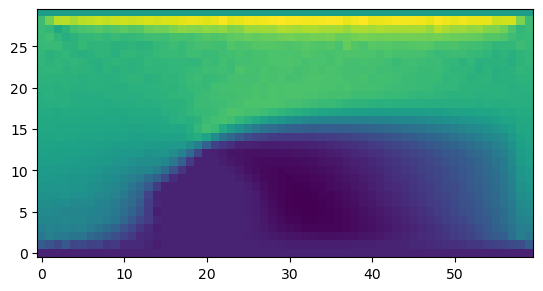

In [32]:
p,u = flow.initial_solution(flow.grid)


u_now = flow.units.lattice.convert_to_numpy(flow.units.lattice.u(simulation.f))
plt.imshow(u_now[0][:,20,:].T, origin="lower")

Text(0.5, 0, 'timesteps (simulation time / LU)')

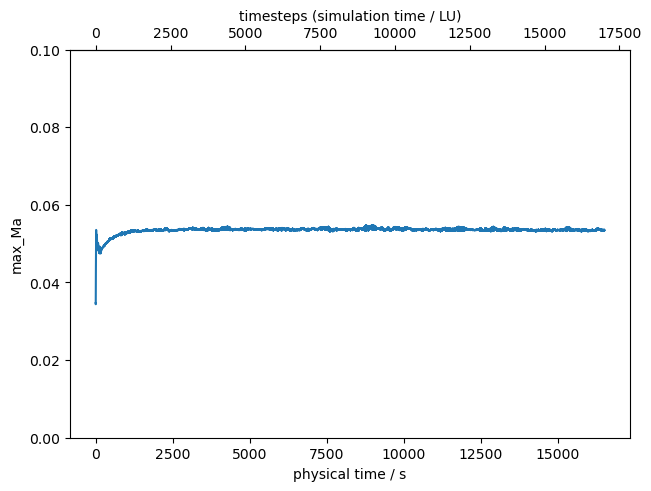

In [33]:
max_u_lu = np.array(max_u_lu_reporter.out)
#print('  stepLU        ', 'timePU        ', 'Cd')
#print(drag_coefficient) # prints: stepLU, timePU, value

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(max_u_lu[:,1],max_u_lu[:,2]/(1/np.sqrt(3)))
#ax.axhline(y=,color='r')
ax.set_xlabel("physical time / s")
ax.set_ylabel("max_Ma")
#ax.set_ylim([0.5,1.6])
ax.set_ylim([0,0.1])
secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
secax.set_xlabel("timesteps (simulation time / LU)")

# output CUDA-VRAM-Data

In [ ]:
# if output_data:
#     ### CUDA-VRAM-summary:
#     output_file = open(output_path + dir_name + "/" + timestamp + "_GPU_memory_summary.txt", "a")
#     output_file.write("DATA for " + timestamp + "\n\n")
#     output_file.write(torch.cuda.memory_summary(lattice.device))
#     output_file.close()
# 
#     try:
#         ### list present torch tensors:
#         output_file = open(output_path + dir_name + "/" + timestamp + "_GPU_list_of_tensors.txt", "a")
#         total_bytes = 0
#         import gc
# 
#         for obj in gc.get_objects():
#             try:
#                 if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
#                     output_file.write("\n" + str(obj.size()) + ", " + str(obj.nelement() * obj.element_size()))
#                     total_bytes = total_bytes + obj.nelement() * obj.element_size()
#             except:
#                 pass
#         # output_file.write("\n\ntotal bytes for tensors:"+str(total_bytes))
#         output_file.close()
# 
#         ### count occurence of tensors in list of tensors:
#         from collections import Counter
# 
#         my_file = open(output_path + dir_name + "/" + timestamp + "_GPU_list_of_tensors.txt", "r")
#         data = my_file.read()
#         my_file.close()
#         data_into_list = data.split("\n")
#         c = Counter(data_into_list)
#         output_file = open(output_path + dir_name + "/" + timestamp + "_GPU_counted_tensors.txt", "a")
#         for k, v in c.items():
#             output_file.write("type,size,bytes: {}, number: {}\n".format(k, v))
#         output_file.write("\ntotal bytes for tensors:" + str(total_bytes))
#         output_file.close()
#     except:
#         print("(!) counting tensors didn't work!")

# output results (text)

## output results in copyable (excel, no headers)